## Mounting

In [1]:
import os
import pandas as pd

current_dir = os.getcwd()

data_path_structure = os.path.join(current_dir, "data", "raw", "patients.csv")
data_path_root = "patients.csv"

if os.path.exists(data_path_structure):
    print(f"Loading from folder structure: {data_path_structure}")
    patients = pd.read_csv(data_path_structure)
elif os.path.exists(data_path_root):
    print(f"Loading from root: {data_path_root}")
    patients = pd.read_csv(data_path_root)
else:
    raise FileNotFoundError("Could not find 'patients.csv'. ")

patients.head(5)


Loading from folder structure: c:\Users\iyedm\OneDrive\Desktop\IVF\data\raw\patients.csv


,patient_id,cycle_number,Age,Protocol,AMH,n_Follicles,E2_day5,AFC,Patient Response
0,Carla F,1,37.0,flexible antagonist,1.87,16.0,930.13,NaN,high
1,Farah Y,2,24.0,fix antag,1.18,5.0,1974.21,NaN,low
2,Ebtisam A,1,32.0,fix antag,1.35,5.0,846.31,NaN,low
3,Hend I,1,24.0,flex anta,1.81,18.0,351.81,17.0,optimal
4,Samira K,2,24.0,flex anta,1.04,9.0,606.70,8.0,low


In [3]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        501 non-null    object 
 1   cycle_number      501 non-null    int64  
 2   Age               495 non-null    float64
 3   Protocol          501 non-null    object 
 4   AMH               447 non-null    float64
 5   n_Follicles       468 non-null    float64
 6   E2_day5           467 non-null    float64
 7   AFC               262 non-null    float64
 8   Patient Response  501 non-null    object 
dtypes: float64(5), int64(1), object(3)
memory usage: 35.4+ KB


In [4]:
patients["patient_id"].nunique()

446

In [5]:
patients["patient_id"]= patients["patient_id"].str.title()

following values: “fixed antagonist”, “flexible antagonist”, “agonist”

## Duplicates

In our context, a female patient can receive during one year (same age) more than one protocole so duplicates are considered the ones having the same  ["patient_id", "cycle_number", "Age", "Protocol"]

In [6]:
dups = patients[patients.duplicated(subset=["patient_id", "cycle_number", "Age", "Protocol"], keep=False)]
dups = dups.sort_values(["patient_id", "cycle_number"])

print("Number of duplicate rows:", len(dups))

dups.head(20)


Number of duplicate rows: 2


,patient_id,cycle_number,Age,Protocol,AMH,n_Follicles,E2_day5,AFC,Patient Response
225,Tamara A,1,28.0,agonist,2.90,21.0,632.77,16.0,optimal
425,Tamara A,1,28.0,agonist,1.83,NaN,4195.00,NaN,optimal


In [7]:
patients["n_missing"] = patients.isna().sum(axis=1)

patients = patients.sort_values(["patient_id", "cycle_number", "Age", "Protocol", "n_missing"])

patients = patients.drop_duplicates(subset=["patient_id", "cycle_number", "Age", "Protocol"], keep="first")

patients = patients.drop(columns=["n_missing"])
patients = patients.reset_index(drop=True)



## De-identify the patients

In [8]:
patient_id_dict = {name: idx + 2500 for idx, name in enumerate(patients["patient_id"])}
patients["patient_id"] = patients["patient_id"].map(patient_id_dict)
patients.head()

,patient_id,cycle_number,Age,Protocol,AMH,n_Follicles,E2_day5,AFC,Patient Response
0,2500,2,27.0,fixed antagonist,NaN,29.0,424.39,NaN,high
1,2501,1,28.0,fix antag,0.76,9.0,817.02,NaN,low
2,2502,1,30.0,flexible antagonist,3.23,22.0,687.52,16.0,optimal
3,2503,1,35.0,fixed anta,2.63,16.0,306.63,NaN,optimal
4,2504,2,32.0,agoni,NaN,3.0,4186.00,5.0,low


## Protcol Column

In [9]:
patients['Protocol'].unique()

array(['fixed antagonist', 'fix antag', 'flexible antagonist',
       'fixed anta', 'agoni', 'flex anta', 'agonist', 'flex antag'],
      dtype=object)

Protocol: The ovarian stimulation protocol for the IVF process; the protocols can be the following values: “fixed antagonist”, “flexible antagonist”, “agonist”

In [10]:
correct_protocol = {
    'agonist': 'agonist',
    'fixed antagonist': 'fixed antagonist',
    'flexible antagonist': 'flexible antagonist',
    "fixed anta": "fixed antagonist",
    'fix antag': "fixed antagonist",
    'agoni': 'agonist',
    'flex anta': 'flexible antagonist',
    'flex antag': 'flexible antagonist'
}

patients["Protocol"] = patients["Protocol"].map(correct_protocol)
patients['Protocol'].unique()

array(['fixed antagonist', 'flexible antagonist', 'agonist'], dtype=object)

There is no missing values here

In [11]:
patients["Protocol"].isna().sum()

0

## E2_day5

In [12]:
patients[patients["E2_day5"].isna()].head(10)

,patient_id,cycle_number,Age,Protocol,AMH,n_Follicles,E2_day5,AFC,Patient Response
37,2537,2,34.0,fixed antagonist,1.56,13.0,NaN,8.0,low
43,2543,1,41.0,agonist,0.62,1.0,NaN,NaN,low
53,2553,1,29.0,fixed antagonist,0.92,7.0,NaN,9.0,low
120,2620,2,25.0,fixed antagonist,0.81,1.0,NaN,NaN,low
130,2630,3,31.0,fixed antagonist,1.04,4.0,NaN,NaN,low
174,2674,1,30.0,flexible antagonist,3.07,18.0,NaN,15.0,optimal
192,2693,1,31.0,flexible antagonist,0.80,5.0,NaN,4.0,low
206,2706,2,35.0,agonist,0.32,2.0,NaN,NaN,low
209,2709,1,26.0,flexible antagonist,0.36,5.0,NaN,NaN,low
227,2727,1,28.0,flexible antagonist,2.15,17.0,NaN,NaN,low


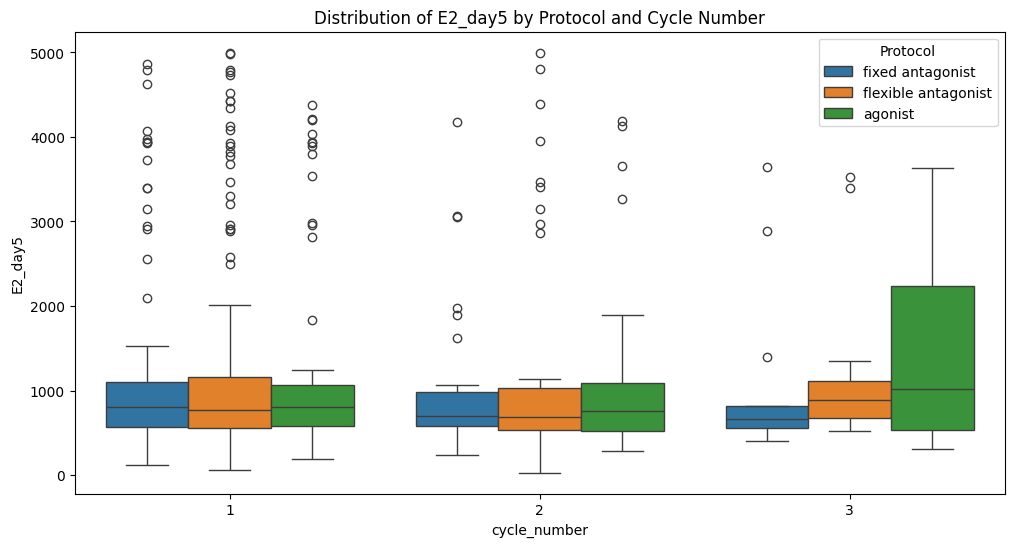

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(x="cycle_number", y="E2_day5", hue="Protocol", data=patients)
plt.title("Distribution of E2_day5 by Protocol and Cycle Number")
plt.show()


In [14]:
skew_per_group = patients.groupby(["Protocol", "cycle_number"])["E2_day5"].skew()
print(skew_per_group)


Protocol             cycle_number
agonist              1               1.700365
                     2               1.849934
                     3               0.952940
fixed antagonist     1               1.907496
                     2               2.435707
                     3               2.151638
flexible antagonist  1               1.709681
                     2               1.883526
                     3               2.429078
Name: E2_day5, dtype: float64


2️⃣ What this tells us for imputation

All groups have skew > 0.95, most > 1 → strongly positively skewed.

This means mean could be distorted by high outliers.

✅ Therefore, it is better to use median per group to fill missing E2_day5.

In [15]:
patients["E2_day5"] = patients.groupby(["Protocol", "cycle_number"])["E2_day5"].transform(lambda x: x.fillna(x.median()))



In [16]:
patients["Protocol"].isna().sum()

0

## Correlation between Features (FOR IMPUTATION)

In [17]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        500 non-null    int64  
 1   cycle_number      500 non-null    int64  
 2   Age               494 non-null    float64
 3   Protocol          500 non-null    object 
 4   AMH               446 non-null    float64
 5   n_Follicles       468 non-null    float64
 6   E2_day5           500 non-null    float64
 7   AFC               262 non-null    float64
 8   Patient Response  500 non-null    object 
dtypes: float64(5), int64(2), object(2)
memory usage: 35.3+ KB


In [19]:
selected_columns = ['Age', 'AMH', 'AFC', 'E2_day5', 'n_Follicles']
corr_matrix = patients[selected_columns].corr()  
print(corr_matrix)


                  Age       AMH       AFC   E2_day5  n_Follicles
Age          1.000000 -0.212821 -0.159744 -0.022702    -0.186928
AMH         -0.212821  1.000000  0.774501 -0.001302     0.914482
AFC         -0.159744  0.774501  1.000000 -0.011181     0.817565
E2_day5     -0.022702 -0.001302 -0.011181  1.000000    -0.014553
n_Follicles -0.186928  0.914482  0.817565 -0.014553     1.000000


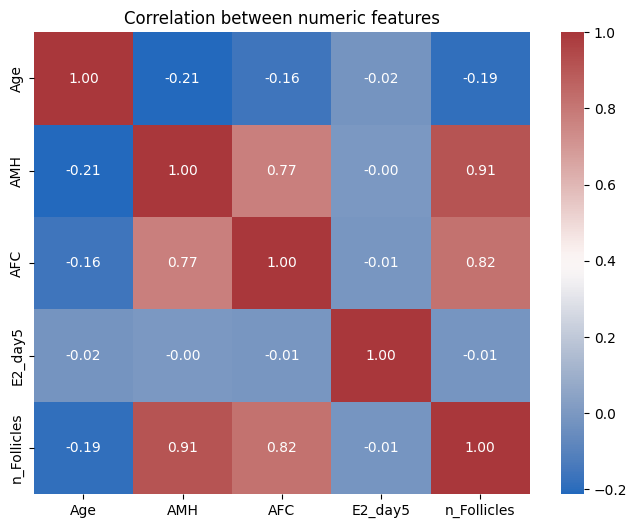

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation between numeric features")
plt.show()


Although medically there is a strong correlation between the Age and the Number of Follicles, in our dataset it is weak so proceeding with the median to impute Age column is safer than running a ML model

## Age

As we can see we don't have outliers or skewed data --> Mean

In [21]:
patients[patients["Age"].isna()]

,patient_id,cycle_number,Age,Protocol,AMH,n_Follicles,E2_day5,AFC,Patient Response
12,2512,1,NaN,agonist,1.71,13.0,981.48,9.0,optimal
38,2538,1,NaN,flexible antagonist,4.73,NaN,317.82,16.0,high
79,2579,1,NaN,fixed antagonist,1.14,4.0,204.00,6.0,low
117,2617,1,NaN,agonist,NaN,1.0,1238.96,4.0,low
205,2705,1,NaN,agonist,3.04,11.0,573.81,16.0,optimal
311,2811,1,NaN,flexible antagonist,1.08,11.0,3679.00,4.0,low


In [22]:
patients.head()

,patient_id,cycle_number,Age,Protocol,AMH,n_Follicles,E2_day5,AFC,Patient Response
0,2500,2,27.0,fixed antagonist,NaN,29.0,424.39,NaN,high
1,2501,1,28.0,fixed antagonist,0.76,9.0,817.02,NaN,low
2,2502,1,30.0,flexible antagonist,3.23,22.0,687.52,16.0,optimal
3,2503,1,35.0,fixed antagonist,2.63,16.0,306.63,NaN,optimal
4,2504,2,32.0,agonist,NaN,3.0,4186.00,5.0,low


In [23]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error


def best_k(patients, cols_for_impute, target):
  k_values = range(1,8)
  errors = []

  data_knn = patients[cols_for_impute]
  known_idx = data_knn[~data_knn[target].isna()].index

  np.random.seed(42)
  mask_idx = np.random.choice(known_idx, size=int(0.2*len(known_idx)), replace=False)
  original_AMH = data_knn.loc[mask_idx, target].copy()
  data_knn.loc[mask_idx, target] = np.nan

  for k in k_values:
      imputer = KNNImputer(n_neighbors=k)
      data_imputed = imputer.fit_transform(data_knn)
      imputed_AMH = pd.DataFrame(data_imputed, columns=cols_for_impute).loc[mask_idx, target]
      mae = mean_absolute_error(original_AMH, imputed_AMH)
      errors.append(mae)
      print(f"k={k} → MAE: {mae:.2f}")

  optimal_k = k_values[np.argmin(errors)]
  print(f"\nOptimal k: {optimal_k} (lowest MAE: {min(errors):.2f})")
  return optimal_k


In [24]:
from sklearn.impute import KNNImputer
import pandas as pd



predictors = ["Age", "n_Follicles"]
data_knn = patients[predictors]

optimal_k = best_k(data_knn, predictors, "Age")

imputer = KNNImputer(n_neighbors=optimal_k)

data_imputed = imputer.fit_transform(data_knn)

patients["Age"] = data_imputed[:, 0]  


k=1 → MAE: 4.87
k=2 → MAE: 4.21
k=3 → MAE: 3.95
k=4 → MAE: 4.13
k=5 → MAE: 3.91
k=6 → MAE: 4.02
k=7 → MAE: 3.96

Optimal k: 5 (lowest MAE: 3.91)


In [25]:
patients[patients["Age"].isna()]

,patient_id,cycle_number,Age,Protocol,AMH,n_Follicles,E2_day5,AFC,Patient Response


## AMH, n_Follicles, AFC

The Multivariate Imputation by Chained Equations (MICE) method is superior to K-Nearest Neighbors (K-NN) for imputing your variables (AMH, n_follicles, and AFC) primarily because of the high percentage of missing data in AFC (51.4%) and the strong correlation between all features. While K-NN uses a local average based on similarity to all features, it becomes unreliable when over half the data for a key variable is missing, as the reference points for 'nearest' neighbors become unstable. MICE, in contrast, uses the iterative, predictive power of a regression model (like Bayesian Ridge) to explicitly leverage the strong $\approx 0.8$ correlation between AFC and the other features. By modeling AFC as a function of the fully observed features and continuously refining the estimates, MICE ensures that the imputed values maintain the original covariance structure, which is crucial for preventing bias in subsequent statistical analyses.

In [26]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

imputation_cols = ['n_Follicles', 'AMH', 'AFC']


imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,             
    random_state=42          
)


patients[imputation_cols] = imputer.fit_transform(patients[imputation_cols])

print("\n--- Imputed Missing Values ---")
print(patients[['n_Follicles', 'AMH', 'AFC']].isnull().sum())



--- Imputed Missing Values ---
n_Follicles    0
AMH            0
AFC            0
dtype: int64


## Cycle number

In [27]:
patients["cycle_number"].unique()

array([2, 1, 3], dtype=int64)

## Patient Response

In [28]:
patients["Patient Response"].unique()

array(['high', 'low', 'optimal', 'Optimal'], dtype=object)

## Feature Engineering

In [29]:
import pandas as pd
from sklearn.preprocessing import  OneHotEncoder

bins = [0, 35, 37, 40, 100]
labels = ['<35', '35-37', '38-40', '>40']

patients['Age_Group'] = pd.cut(patients['Age'], bins=bins, labels=labels, right= False)
risk_mapping = {'<35': 0, '35-37': 1, '38-40': 2, '>40': 3}
patients['Age_Group'] = patients['Age_Group'].map(risk_mapping)


In [30]:
patients.head(10)

,patient_id,cycle_number,Age,Protocol,AMH,n_Follicles,E2_day5,AFC,Patient Response,Age_Group
0,2500,2,27.0,fixed antagonist,3.977731,29.0,424.39,19.152459,high,0
1,2501,1,28.0,fixed antagonist,0.760000,9.0,817.02,8.441921,low,0
2,2502,1,30.0,flexible antagonist,3.230000,22.0,687.52,16.000000,optimal,0
3,2503,1,35.0,fixed antagonist,2.630000,16.0,306.63,12.373407,optimal,1
4,2504,2,32.0,agonist,0.588889,3.0,4186.00,5.000000,low,0
5,2505,1,30.0,flexible antagonist,3.500000,27.0,1029.29,25.000000,high,0
6,2506,1,41.0,fixed antagonist,1.060000,1.0,689.37,11.000000,high,3
7,2507,1,39.0,flexible antagonist,0.240000,1.0,209.13,4.346230,low,2
8,2508,1,29.0,fixed antagonist,2.510000,17.0,200.37,9.000000,optimal,0
9,2509,1,43.0,fixed antagonist,1.180000,9.0,1432.52,13.000000,high,3


## Normalization

In [31]:
patients_before_normalization = patients.copy()

In [32]:
import numpy as np
import pandas as pd
from scipy import stats

def column_diagnostics(df, col):
    s = df[col]

    count = s.count()
    missing_pct = s.isna().mean()
    min_val = s.min()

    p = s.quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

    skew = s.skew()
    kurtosis = s.kurtosis()

    frac_zeros = (s == 0).mean()
    frac_negative = (s < 0).mean()

    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    iqr_lower = q1 - 1.5 * iqr
    iqr_upper = q3 + 1.5 * iqr
    frac_outliers = ((s < iqr_lower) | (s > iqr_upper)).mean()

    try:
        if count < 5000:
            stat, pvalue = stats.shapiro(s.dropna())
        else:
            stat, pvalue = np.nan, np.nan
    except:
        stat, pvalue = np.nan, np.nan

    return {
        "count": count,
        "missing_pct": missing_pct,
        "min": min_val,
        "p1": p.loc[0.01],
        "p5": p.loc[0.05],
        "p25": p.loc[0.25],
        "median": p.loc[0.5],
        "p75": p.loc[0.75],
        "p95": p.loc[0.95],
        "p99": p.loc[0.99],
        "skew": skew,
        "kurtosis": kurtosis,
        "frac_zeros": frac_zeros,
        "frac_negative": frac_negative,
        "iqr_lower": iqr_lower,
        "iqr_upper": iqr_upper,
        "frac_outliers_iqr": frac_outliers,
        "normality_test": "shapiro",
        "normality_pvalue": pvalue
    }


In [33]:
column_diagnostics(patients, "AFC")

{'count': 500,
 'missing_pct': 0.0,
 'min': 3.0,
 'p1': 3.0,
 'p5': 4.0,
 'p25': 8.0,
 'median': 12.0,
 'p75': 16.287847503534696,
 'p95': 24.047798514889653,
 'p99': 28.0,
 'skew': 0.530704954463529,
 'kurtosis': -0.4123897229412581,
 'frac_zeros': 0.0,
 'frac_negative': 0.0,
 'iqr_lower': -4.431771255302044,
 'iqr_upper': 28.719618758836738,
 'frac_outliers_iqr': 0.004,
 'normality_test': 'shapiro',
 'normality_pvalue': 3.3848080048443776e-10}

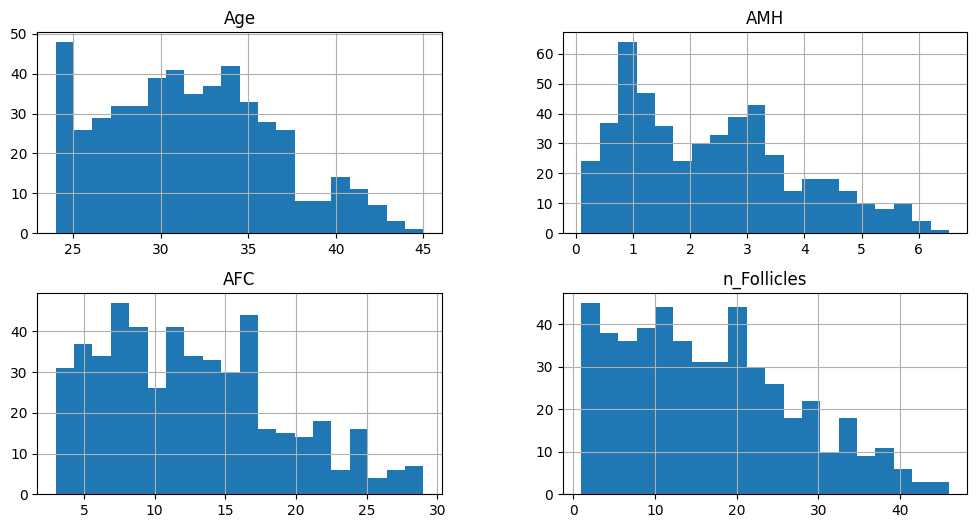

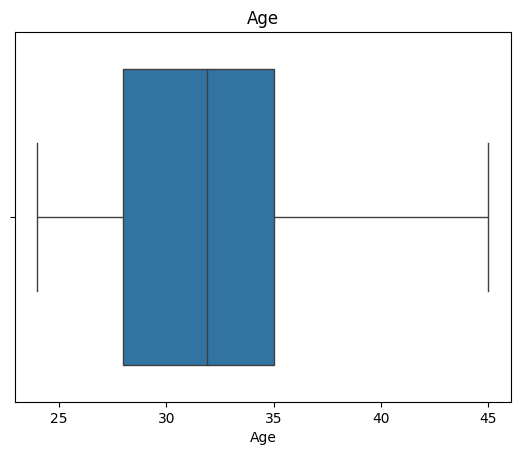

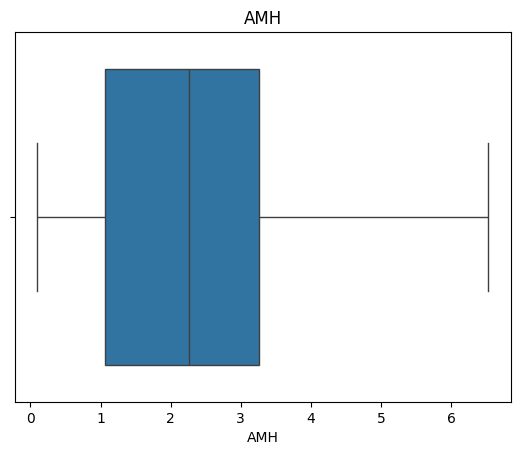

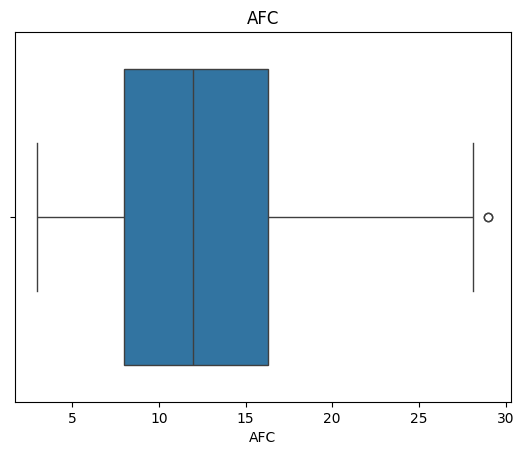

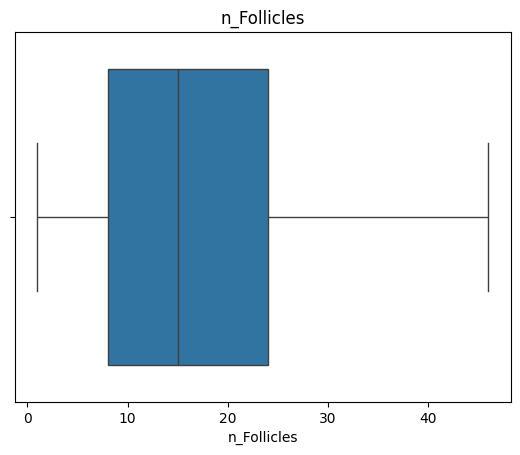

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt


numeric_cols = ["Age", "AMH", "AFC", "n_Follicles"]
patients_before_normalization[numeric_cols].hist(bins=20, figsize=(12,6))
plt.show()

for col in numeric_cols:
    sns.boxplot(x=patients_before_normalization[col])
    plt.title(col)
    plt.show()


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

patients['Age'] = scaler.fit_transform(patients[['Age']])



In [35]:
import numpy as np
from sklearn.preprocessing import StandardScaler

patients['n_Follicles'] = np.sqrt(patients['n_Follicles'])

scaler = StandardScaler()
patients['n_Follicles'] = scaler.fit_transform(patients[['n_Follicles']])



In [36]:
import numpy as np
from sklearn.preprocessing import StandardScaler


patients['AMH'] = np.sqrt(patients['AMH'])

scaler = StandardScaler()
patients['AMH'] = scaler.fit_transform(patients[['AMH']])



In [37]:
import numpy as np
from sklearn.preprocessing import StandardScaler


patients['E2_day5'] = np.log(patients['E2_day5'])

scaler = StandardScaler()
patients['E2_day5'] = scaler.fit_transform(patients[['E2_day5']])



In [38]:
import numpy as np
from sklearn.preprocessing import StandardScaler

patients['AFC'] = np.sqrt(patients['AFC'])

scaler = StandardScaler()
patients['AFC'] = scaler.fit_transform(patients[['AFC']])



## Encoding & Correlations

In [39]:
selected_columns = ['Age', 'AMH', 'AFC', 'E2_day5', 'n_Follicles', 'Age_Group']
patients[selected_columns].corr()

,Age,AMH,AFC,E2_day5,n_Follicles,Age_Group
Age,1.000000,-0.220806,-0.163904,-0.038865,-0.201649,0.803484
AMH,-0.220806,1.000000,0.836736,-0.015392,0.904806,-0.209601
AFC,-0.163904,0.836736,1.000000,-0.024825,0.884517,-0.163969
E2_day5,-0.038865,-0.015392,-0.024825,1.000000,-0.005434,0.000619
n_Follicles,-0.201649,0.904806,0.884517,-0.005434,1.000000,-0.185606
Age_Group,0.803484,-0.209601,-0.163969,0.000619,-0.185606,1.000000


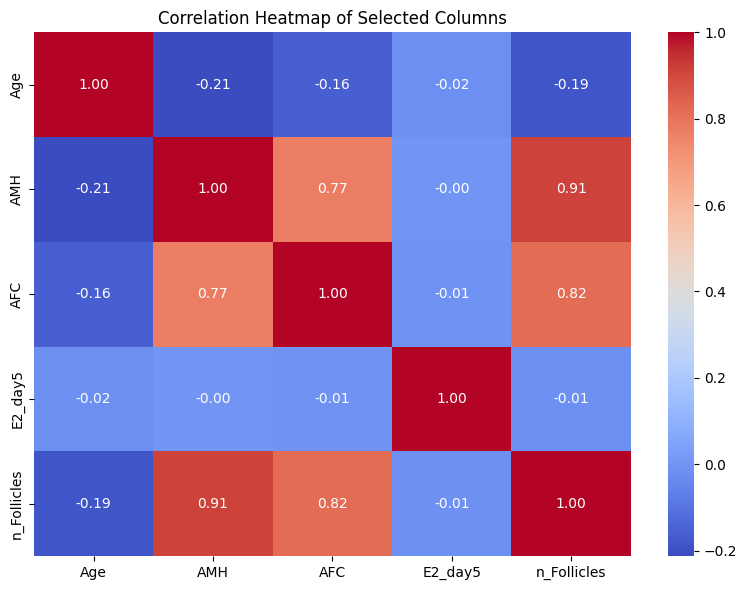

In [40]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Selected Columns')
plt.tight_layout()
plt.show()

In [41]:
patients["Protocol"].unique()

array(['fixed antagonist', 'flexible antagonist', 'agonist'], dtype=object)

In [42]:
patients_encoded = pd.get_dummies(patients, columns=["Protocol", "Age_Group"], drop_first=True)


In [43]:

correct_mapping = {'low': 0, 'optimal': 1, 'high': 2}

patients_encoded['Patient Response'] = patients_encoded['Patient Response'].map(correct_mapping)

In [44]:
patients_encoded.head()

,patient_id,cycle_number,Age,AMH,n_Follicles,E2_day5,AFC,Patient Response,Protocol_fixed antagonist,Protocol_flexible antagonist,Age_Group_1,Age_Group_2,Age_Group_3
0,2500,2,-1.021581,1.075909,1.124473,-0.947336,1.062954,2.0,True,False,False,False,False
1,2501,1,-0.806579,-1.144982,-0.596132,-0.078317,-0.598786,0.0,True,False,False,False,False
2,2502,1,-0.376573,0.685785,0.623297,-0.307274,0.637759,1.0,False,True,False,False,False
3,2503,1,0.698440,0.338614,0.125246,-1.378536,0.092737,1.0,True,False,True,False,False
4,2504,2,0.053432,-1.351491,-1.510802,2.089334,-1.355095,0.0,False,False,False,False,False


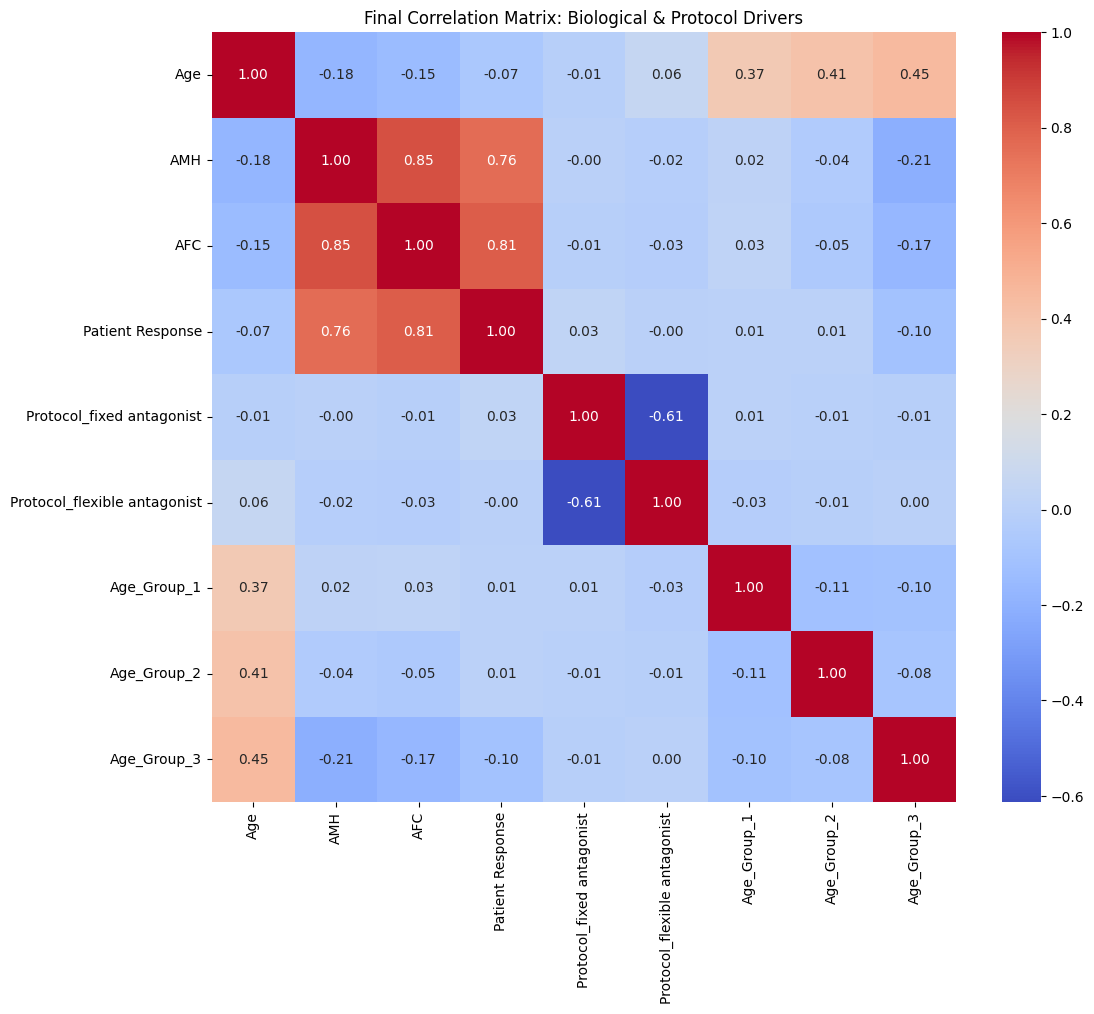

In [45]:
cols_to_drop = ['patient_id', 'cycle_number', 'n_Follicles', 'E2_day5']

patients_encoded = patients_encoded.drop(columns=cols_to_drop, errors='ignore')


patients_encoded = patients_encoded.astype(float)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(patients_encoded.corr(method='spearman'),
            annot=True,
            cmap='coolwarm',
            fmt=".2f")
plt.title("Final Correlation Matrix: Biological & Protocol Drivers")
plt.show()

In [46]:
patients_encoded.head()

,Age,AMH,AFC,Patient Response,Protocol_fixed antagonist,Protocol_flexible antagonist,Age_Group_1,Age_Group_2,Age_Group_3
0,-1.021581,1.075909,1.062954,2.0,1.0,0.0,0.0,0.0,0.0
1,-0.806579,-1.144982,-0.598786,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.376573,0.685785,0.637759,1.0,0.0,1.0,0.0,0.0,0.0
3,0.698440,0.338614,0.092737,1.0,1.0,0.0,1.0,0.0,0.0
4,0.053432,-1.351491,-1.355095,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
patients_encoded = patients_encoded.dropna(subset=['Patient Response'])

In [48]:
X = patients_encoded.drop(columns=["Patient Response"])
y = patients_encoded["Patient Response"]


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## EDA

In [50]:
patients_before_normalization.head()

,patient_id,cycle_number,Age,Protocol,AMH,n_Follicles,E2_day5,AFC,Patient Response,Age_Group
0,2500,2,27.0,fixed antagonist,3.977731,29.0,424.39,19.152459,high,0
1,2501,1,28.0,fixed antagonist,0.760000,9.0,817.02,8.441921,low,0
2,2502,1,30.0,flexible antagonist,3.230000,22.0,687.52,16.000000,optimal,0
3,2503,1,35.0,fixed antagonist,2.630000,16.0,306.63,12.373407,optimal,1
4,2504,2,32.0,agonist,0.588889,3.0,4186.00,5.000000,low,0


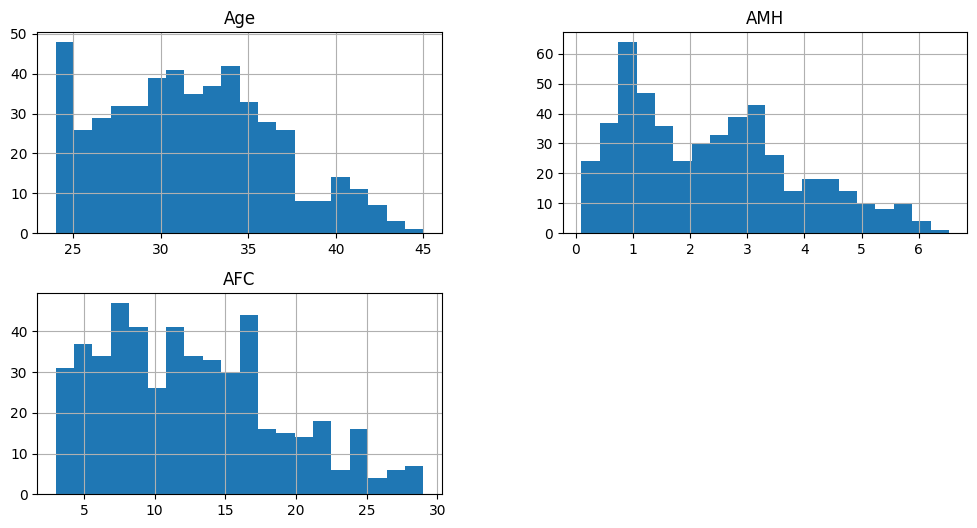

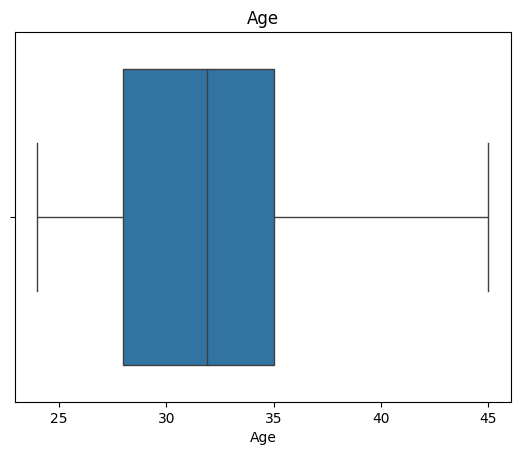

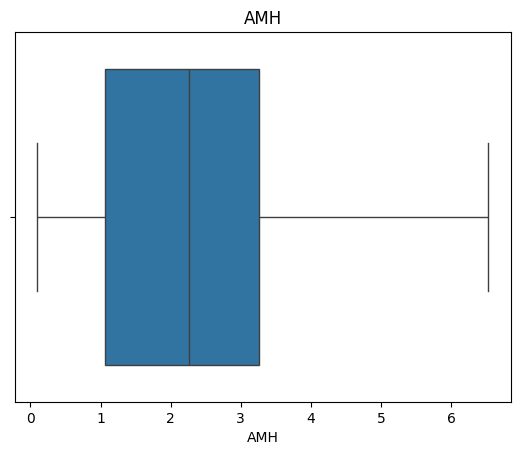

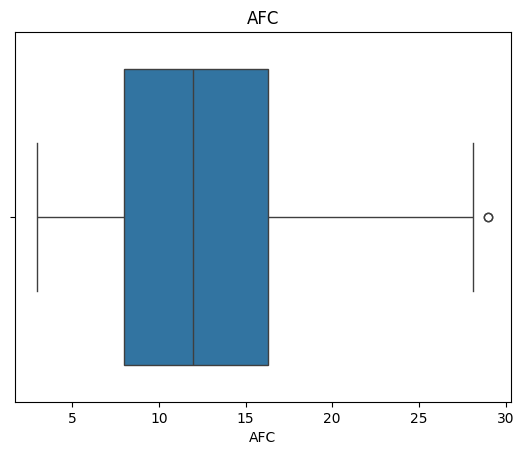

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt


numeric_cols = ["Age", "AMH", "AFC"]
patients_before_normalization[numeric_cols].hist(bins=20, figsize=(12,6))
plt.show()

for col in numeric_cols:
    sns.boxplot(x=patients_before_normalization[col])
    plt.title(col)
    plt.show()


In [52]:

def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    return series[(series < lower) | (series > upper)]

# Example for AMH
outliers_amh = detect_outliers_iqr(patients["E2_day5"])
print(len(outliers_amh), "outliers in E2_day5")



81 outliers in E2_day5


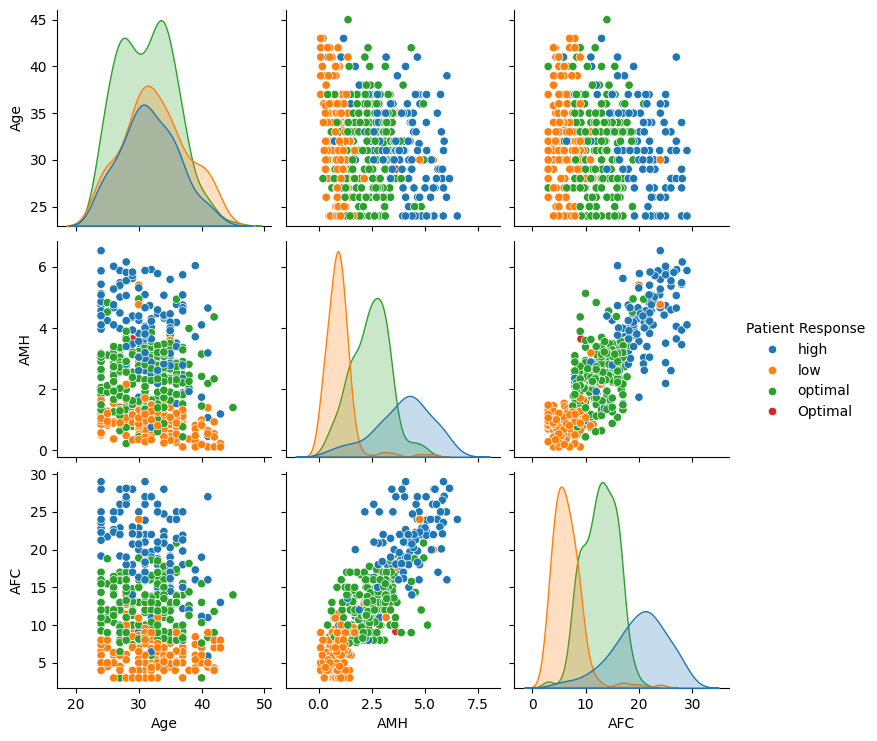

In [53]:
sns.pairplot(patients_before_normalization, vars=["Age","AMH","AFC"], hue="Patient Response")
plt.show()


## Models Choice (See DATA IMBALANCE first)

In [54]:
patients_encoded.head()

,Age,AMH,AFC,Patient Response,Protocol_fixed antagonist,Protocol_flexible antagonist,Age_Group_1,Age_Group_2,Age_Group_3
0,-1.021581,1.075909,1.062954,2.0,1.0,0.0,0.0,0.0,0.0
1,-0.806579,-1.144982,-0.598786,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.376573,0.685785,0.637759,1.0,0.0,1.0,0.0,0.0,0.0
3,0.698440,0.338614,0.092737,1.0,1.0,0.0,1.0,0.0,0.0
4,0.053432,-1.351491,-1.355095,0.0,0.0,0.0,0.0,0.0,0.0


--- Class Counts ---
Patient Response
optimal    224
low        153
high       122
Optimal      1
Name: count, dtype: int64
class_imbalance_plot.png


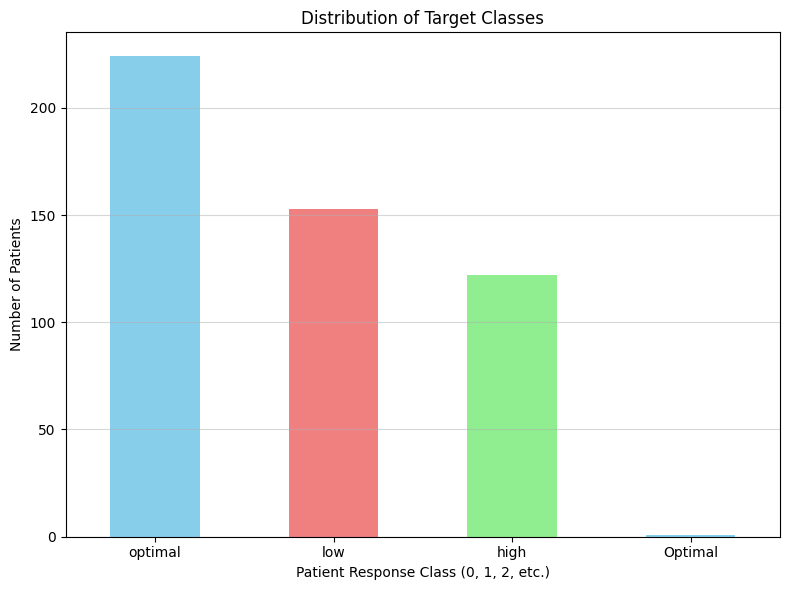

In [55]:
import pandas as pd
import matplotlib.pyplot as plt


df = patients
df = df.dropna(subset=['Patient Response'])

target_column = 'Patient Response'

class_counts = df[target_column].value_counts()

print("--- Class Counts ---")
print(class_counts)

plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])

plt.title('Distribution of Target Classes')
plt.xlabel('Patient Response Class (0, 1, 2, etc.)')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0) 
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

plt.savefig('class_imbalance_plot.png')

print("class_imbalance_plot.png")

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score


def get_best_model(model, params, X, y):
  recall_weighted_scorer = make_scorer(f1_score, average='weighted')

  grid = GridSearchCV(
      model,
      params,
      cv=5,
      error_score=0,
      scoring=recall_weighted_scorer,  
      n_jobs=-1
  )
  grid.fit(X, y)
  print(f"--- {model.__class__.__name__} ---")
  print(f"Best Weighted metric: {grid.best_score_:.4f}")
  print(f"Best Parameters: {grid.best_params_}")
  return grid.best_estimator_

In [57]:
from sklearn.model_selection import GridSearchCV

def get_best_model(model, params, X, y):
    roc_metric = 'roc_auc_ovr_weighted'

    grid = GridSearchCV(
        model,
        params,
        cv=5,
        error_score=0,
        scoring=roc_metric,  
        n_jobs=-1
    )

    grid.fit(X, y)

    print(f"--- {model.__class__.__name__} ---")
    print(f"Best Weighted ROC AUC: {grid.best_score_:.4f}")
    print(f"Best Parameters: {grid.best_params_}")

    return grid.best_estimator_

In [58]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier  

models = {
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'LogisticRegression': LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42, eval_metric='mlogloss') # <--- Added XGBoost here
}

params = {
    'RandomForest': {
        'n_estimators': [100, 300],
        'max_depth': [3, 5, 7, None],
        'min_samples_leaf': [1, 2, 4]
    },
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    },
    'XGBClassifier': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

best_estimators = {}

for name, model in models.items():
    if name in params: 
        print(f"--- Running {name} ---")
        best_estimators[name] = get_best_model(model, params[name], X_train, y_train)
        print("-" * 30)

--- Running RandomForest ---
--- RandomForestClassifier ---
Best Weighted ROC AUC: 0.9267
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 100}
------------------------------
--- Running LogisticRegression ---
--- LogisticRegression ---
Best Weighted ROC AUC: 0.9173
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
------------------------------
--- Running SVM ---
--- SVC ---
Best Weighted ROC AUC: 0.9317
Best Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
------------------------------
--- Running XGBClassifier ---
--- XGBClassifier ---
Best Weighted ROC AUC: 0.9259
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
------------------------------


In [62]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import cross_val_score


estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, class_weight='balanced', random_state=42)),
    ('svm', SVC(C=0.1, kernel='linear', gamma='scale', probability=True, class_weight='balanced', random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, objective='multi:softprob', eval_metric='mlogloss', random_state=42)),
    ('lr', LogisticRegression(C=0.1, penalty='l1', solver='liblinear', class_weight='balanced', random_state=42))
]


voting_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5,  # Internal cross-validation to train the meta-model
    n_jobs=-1
)

print("--- Training Stacking Classifier ---")
# Evaluate just like before
scores_stack = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='roc_auc_ovr_weighted')

print(f"Stacking Average AUC: {scores_stack.mean():.4f}")
print(f"Stacking Stability: {scores_stack.std():.4f}")

--- Training Stacking Classifier ---
Stacking Average AUC: 0.9316
Stacking Stability: 0.0411


## Feature Selection

###  Pearson correlation to select features

In [63]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

class CustomMutualInfoSelector(TransformerMixin, BaseEstimator):
    def __init__(self, threshold=None, top_k=None):
        self.threshold = threshold
        self.top_k = top_k
        self.cols_to_keep = []
        self.mi_scores = None

    def fit(self, X, y=None):
        self.mi_scores = mutual_info_classif(X, y, random_state=42)

        mi_series = pd.Series(self.mi_scores, index=X.columns)

        if self.threshold is not None:
            self.cols_to_keep = mi_series[mi_series > self.threshold].index.tolist()
        elif self.top_k is not None:
            self.cols_to_keep = mi_series.nlargest(self.top_k).index.tolist()
        else:
            self.cols_to_keep = X.columns.tolist()

        return self

    def transform(self, X):
        # Return only the selected columns
        if isinstance(X, pd.DataFrame):
            return X[self.cols_to_keep]
        return X


models_to_test = {
    'RandomForest': RandomForestClassifier(
        max_depth=7, min_samples_leaf=1, n_estimators=300,
        class_weight='balanced', random_state=42
    ),
    'LogisticRegression': LogisticRegression(
        C=0.1, penalty='l1', solver='liblinear',
        class_weight='balanced', random_state=42
    ),
    'SVM': SVC(
        C=1, gamma=0.01, kernel='rbf', probability=True,
        class_weight='balanced', random_state=42
    ),
    'XGBClassifier': xgb.XGBClassifier(
        colsample_bytree=0.8, learning_rate=0.1, max_depth=3,
        n_estimators=100, subsample=1.0,
        objective='multi:softprob', eval_metric='mlogloss', random_state=42
    )
}

pipe_params = {
    'feature_selection__threshold': [0.0, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]
}

results = {}

print("--- Starting Feature Selection Grid Search ---")

for name, model in models_to_test.items():
    print(f"\nOptimization for: {name}")

    # Create the pipeline for this specific model
    pipeline = Pipeline([
        ('feature_selection', CustomMutualInfoSelector()),
        ('classifier', model)
    ])

    # Run Grid Search (using your existing function)
    # This finds the best threshold for THIS model
    best_pipe = get_best_model(pipeline, pipe_params, X_train, y_train)

    # Extract results
    best_selector = best_pipe.named_steps['feature_selection']
    kept_features = best_selector.cols_to_keep

    print(f"  > Original Features: {X_train.shape[1]}")
    print(f"  > Selected Features: {len(kept_features)}")
    print(f"  > Features Kept: {kept_features}")

    results[name] = best_pipe

print("\n--- Optimization Complete ---")

--- Starting Feature Selection Grid Search ---

Optimization for: RandomForest
--- Pipeline ---
Best Weighted ROC AUC: 0.9290
Best Parameters: {'feature_selection__threshold': 0.0}
  > Original Features: 8
  > Selected Features: 4
  > Features Kept: ['Age', 'AMH', 'AFC', 'Protocol_flexible antagonist']

Optimization for: LogisticRegression
--- Pipeline ---
Best Weighted ROC AUC: 0.9226
Best Parameters: {'feature_selection__threshold': 0.03}
  > Original Features: 8
  > Selected Features: 4
  > Features Kept: ['Age', 'AMH', 'AFC', 'Protocol_flexible antagonist']

Optimization for: SVM
--- Pipeline ---
Best Weighted ROC AUC: 0.9322
Best Parameters: {'feature_selection__threshold': 0.0}
  > Original Features: 8
  > Selected Features: 4
  > Features Kept: ['Age', 'AMH', 'AFC', 'Protocol_flexible antagonist']

Optimization for: XGBClassifier
--- Pipeline ---
Best Weighted ROC AUC: 0.9255
Best Parameters: {'feature_selection__threshold': 0.0}
  > Original Features: 8
  > Selected Features: 4

### Hypothesis testing

In [64]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


models_to_test = {
    'RandomForest': RandomForestClassifier(
        max_depth=7, min_samples_leaf=1, n_estimators=300,
        class_weight='balanced', random_state=42
    ),
    'LogisticRegression': LogisticRegression(
        C=0.1, penalty='l1', solver='liblinear',
        class_weight='balanced', random_state=42
    ),
    'SVM': SVC(
        C=1, gamma=0.01, kernel='rbf', probability=True,
        class_weight='balanced', random_state=42
    ),
    'XGBClassifier': xgb.XGBClassifier(
        colsample_bytree=0.8, learning_rate=0.1, max_depth=3,
        n_estimators=100, subsample=1.0,
        objective='multi:softprob', eval_metric='mlogloss', random_state=42
    )
}


n_features = X_train.shape[1]
k_range = list(range(1, n_features + 1))
k_range.append('all')

pipe_params = {
    'k_best__k': k_range
}

print("--- Running ANOVA F-test (SelectKBest) on Individual Models ---")

results_anova = {}

for name, model in models_to_test.items():
    print(f"\nOptimization for: {name}")

    pipeline = Pipeline([
        ('k_best', SelectKBest(score_func=f_classif)),
        ('classifier', model)
    ])


    best_pipe = get_best_model(pipeline, pipe_params, X_train, y_train)

    best_selector = best_pipe.named_steps['k_best']
    support_mask = best_selector.get_support()

    print(f"  > Best k: {best_selector.k}")
    print(f"  > Selected: {sum(support_mask)} / {n_features}")
    print(f"  > Features Kept: {X_train.columns[support_mask].tolist()}")

    results_anova[name] = best_pipe

print("\n--- ANOVA Optimization Complete ---")

--- Running ANOVA F-test (SelectKBest) on Individual Models ---

Optimization for: RandomForest
--- Pipeline ---
Best Weighted ROC AUC: 0.9264
Best Parameters: {'k_best__k': 5}
  > Best k: 5
  > Selected: 5 / 8
  > Features Kept: ['Age', 'AMH', 'AFC', 'Protocol_fixed antagonist', 'Age_Group_3']

Optimization for: LogisticRegression
--- Pipeline ---
Best Weighted ROC AUC: 0.9218
Best Parameters: {'k_best__k': 2}
  > Best k: 2
  > Selected: 2 / 8
  > Features Kept: ['AMH', 'AFC']

Optimization for: SVM
--- Pipeline ---
Best Weighted ROC AUC: 0.9324
Best Parameters: {'k_best__k': 5}
  > Best k: 5
  > Selected: 5 / 8
  > Features Kept: ['Age', 'AMH', 'AFC', 'Protocol_fixed antagonist', 'Age_Group_3']

Optimization for: XGBClassifier
--- Pipeline ---
Best Weighted ROC AUC: 0.9259
Best Parameters: {'k_best__k': 8}
  > Best k: 8
  > Selected: 8 / 8
  > Features Kept: ['Age', 'AMH', 'AFC', 'Protocol_fixed antagonist', 'Protocol_flexible antagonist', 'Age_Group_1', 'Age_Group_2', 'Age_Group_3']

## Model based selection

#### Tree-based models




In [65]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


models_to_test = {
    'RandomForest': RandomForestClassifier(
        max_depth=7, min_samples_leaf=1, n_estimators=300,
        class_weight='balanced', random_state=42
    ),
    'LogisticRegression': LogisticRegression(
        C=0.1, penalty='l1', solver='liblinear',
        class_weight='balanced', random_state=42
    ),
    'SVM': SVC(
        C=1, gamma=0.01, kernel='rbf', probability=True,
        class_weight='balanced', random_state=42
    ),
    'XGBClassifier': xgb.XGBClassifier(
        colsample_bytree=0.8, learning_rate=0.1, max_depth=3,
        n_estimators=100, subsample=1.0,
        objective='multi:softprob', eval_metric='mlogloss', random_state=42
    )
}

pipe_params = {
    # 'mean': Keep features with importance > average
    # 'median': Keep top 50%
    # '1.25*mean': Very strict (keep only the absolute best)
    'select__threshold': ["mean", "median", "1.25*mean", 0.01],

    'select__estimator__max_depth': [None, 3, 5]
}

print("--- Running SelectFromModel (Embedded Selection) on Individual Models ---")

results_embedded = {}

for name, model in models_to_test.items():
    print(f"\nOptimization for: {name}")

    # Create the pipeline:
    # Step 1: Selection Judge (RandomForest) -> Selects features
    # Step 2: Classifier (Your Best Model) -> Learns on selected features
    pipeline = Pipeline([
        ('select', SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, random_state=42))),
        ('classifier', model)
    ])


    best_pipe = get_best_model(pipeline, pipe_params, X_train, y_train)

    best_selector = best_pipe.named_steps['select']
    support_mask = best_selector.get_support()

    winning_threshold = best_selector.threshold

    print(f"  > Best Selection Threshold Used: {winning_threshold}")
    print(f"  > Selected: {sum(support_mask)} / {X_train.shape[1]}")
    print(f"  > Features Kept: {X_train.columns[support_mask].tolist()}")

    results_embedded[name] = best_pipe

print("\n--- Embedded Optimization Complete ---")

--- Running SelectFromModel (Embedded Selection) on Individual Models ---

Optimization for: RandomForest
--- Pipeline ---
Best Weighted ROC AUC: 0.9291
Best Parameters: {'select__estimator__max_depth': None, 'select__threshold': 0.01}
  > Best Selection Threshold Used: 0.01
  > Selected: 5 / 8
  > Features Kept: ['Age', 'AMH', 'AFC', 'Protocol_fixed antagonist', 'Protocol_flexible antagonist']

Optimization for: LogisticRegression
--- Pipeline ---
Best Weighted ROC AUC: 0.9218
Best Parameters: {'select__estimator__max_depth': None, 'select__threshold': 'mean'}
  > Best Selection Threshold Used: mean
  > Selected: 2 / 8
  > Features Kept: ['AMH', 'AFC']

Optimization for: SVM
--- Pipeline ---
Best Weighted ROC AUC: 0.9328
Best Parameters: {'select__estimator__max_depth': 3, 'select__threshold': 0.01}
  > Best Selection Threshold Used: 0.01
  > Selected: 4 / 8
  > Features Kept: ['Age', 'AMH', 'AFC', 'Age_Group_3']

Optimization for: XGBClassifier
--- Pipeline ---
Best Weighted ROC AUC:

We can see that there is an improvement as we beat .9324 to .9328

#### Linear models

In [66]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


models_to_test = {
    'RandomForest': RandomForestClassifier(
        max_depth=7, min_samples_leaf=1, n_estimators=300,
        class_weight='balanced', random_state=42
    ),
    'LogisticRegression': LogisticRegression(
        C=0.1, penalty='l1', solver='liblinear',
        class_weight='balanced', random_state=42
    ),
    'SVM': SVC(
        C=1, gamma=0.01, kernel='rbf', probability=True,
        class_weight='balanced', random_state=42
    ),
    'XGBClassifier': xgb.XGBClassifier(
        colsample_bytree=0.8, learning_rate=0.1, max_depth=3,
        n_estimators=100, subsample=1.0,
        objective='multi:softprob', eval_metric='mlogloss', random_state=42
    )
}

pipe_params = {
    # Threshold: "mean" is standard, but smaller values allow L1 to work naturally
    'select__threshold': [1e-5, "mean", "median", 0.01],

    # Penalty: L1 (Lasso) forces zeros; L2 (Ridge) shrinks weights
    'select__estimator__penalty': ['l1', 'l2'],

    # Strength: Smaller C = Stronger penalty (fewer features kept)
    'select__estimator__C': [0.01, 0.1, 1, 10]
}

print("--- Running Linear Feature Selection (L1/L2) on Individual Models ---")

results_linear = {}

for name, model in models_to_test.items():
    print(f"\nOptimization for: {name}")

    selector_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

    pipeline = Pipeline([
        ('select', SelectFromModel(estimator=selector_model)),
        ('classifier', model)
    ])

    best_pipe = get_best_model(pipeline, pipe_params, X_train, y_train)

    best_selector = best_pipe.named_steps['select']
    support_mask = best_selector.get_support()

    winning_threshold = best_selector.threshold
    # Get the penalty/C used by the internal estimator
    winning_estimator = best_selector.estimator_

    print(f"  > Best Selection Params: C={winning_estimator.C}, Penalty={winning_estimator.penalty}, Threshold={winning_threshold}")
    print(f"  > Selected: {sum(support_mask)} / {X_train.shape[1]}")
    print(f"  > Features Kept: {X_train.columns[support_mask].tolist()}")

    results_linear[name] = best_pipe

print("\n--- Linear Optimization Complete ---")

--- Running Linear Feature Selection (L1/L2) on Individual Models ---

Optimization for: RandomForest
--- Pipeline ---
Best Weighted ROC AUC: 0.9319
Best Parameters: {'select__estimator__C': 0.1, 'select__estimator__penalty': 'l1', 'select__threshold': 1e-05}
  > Best Selection Params: C=0.1, Penalty=l1, Threshold=1e-05
  > Selected: 3 / 8
  > Features Kept: ['Age', 'AMH', 'AFC']

Optimization for: LogisticRegression
--- Pipeline ---
Best Weighted ROC AUC: 0.9223
Best Parameters: {'select__estimator__C': 1, 'select__estimator__penalty': 'l1', 'select__threshold': 'median'}
  > Best Selection Params: C=1, Penalty=l1, Threshold=median
  > Selected: 4 / 8
  > Features Kept: ['AMH', 'AFC', 'Protocol_fixed antagonist', 'Age_Group_3']

Optimization for: SVM
--- Pipeline ---
Best Weighted ROC AUC: 0.9325
Best Parameters: {'select__estimator__C': 0.1, 'select__estimator__penalty': 'l1', 'select__threshold': 1e-05}
  > Best Selection Params: C=0.1, Penalty=l1, Threshold=1e-05
  > Selected: 3 / 

In [67]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


models_to_test = {
    'RandomForest': RandomForestClassifier(
        max_depth=7, min_samples_leaf=1, n_estimators=300,
        class_weight='balanced', random_state=42
    ),
    'LogisticRegression': LogisticRegression(
        C=0.1, penalty='l1', solver='liblinear',
        class_weight='balanced', random_state=42
    ),
    'SVM': SVC(
        C=1, gamma=0.01, kernel='rbf', probability=True,
        class_weight='balanced', random_state=42
    ),
    'XGBClassifier': xgb.XGBClassifier(
        colsample_bytree=0.8, learning_rate=0.1, max_depth=3,
        n_estimators=100, subsample=1.0,
        objective='multi:softprob', eval_metric='mlogloss', random_state=42
    )
}

svc_pipe_params = [
    {
        'select__threshold': ["mean", "median", 1e-5],
        'select__estimator__penalty': ['l1'],
        'select__estimator__loss': ['squared_hinge'],
        'select__estimator__dual': [False], # Required for L1
        'select__estimator__C': [0.01, 0.1, 1]
    },
    {
        'select__threshold': ["mean", "median"],
        'select__estimator__penalty': ['l2'],
        'select__estimator__loss': ['squared_hinge', 'hinge'],
        'select__estimator__dual': [True],
        'select__estimator__C': [0.01, 0.1, 1]
    }
]

print("--- Running LinearSVC Feature Selection on Individual Models ---")

results_svc = {}

for name, model in models_to_test.items():
    print(f"\nOptimization for: {name}")


    selector_model = LinearSVC(class_weight='balanced', random_state=42)

    pipeline = Pipeline([
        ('select', SelectFromModel(estimator=selector_model)),
        ('classifier', model)
    ])


    best_pipe = get_best_model(pipeline, svc_pipe_params, X_train, y_train)

    best_selector = best_pipe.named_steps['select']
    support_mask = best_selector.get_support()

    winning_estimator = best_selector.estimator_
    winning_threshold = best_selector.threshold

    print(f"  > Best Selection Params: C={winning_estimator.C}, Penalty={winning_estimator.penalty}, Loss={winning_estimator.loss}, Threshold={winning_threshold}")
    print(f"  > Selected: {sum(support_mask)} / {X_train.shape[1]}")
    print(f"  > Features Kept: {X_train.columns[support_mask].tolist()}")

    results_svc[name] = best_pipe

print("\n--- LinearSVC Optimization Complete ---")

--- Running LinearSVC Feature Selection on Individual Models ---

Optimization for: RandomForest
--- Pipeline ---
Best Weighted ROC AUC: 0.9259
Best Parameters: {'select__estimator__C': 0.01, 'select__estimator__dual': False, 'select__estimator__loss': 'squared_hinge', 'select__estimator__penalty': 'l1', 'select__threshold': 'median'}
  > Best Selection Params: C=0.01, Penalty=l1, Loss=squared_hinge, Threshold=median
  > Selected: 8 / 8
  > Features Kept: ['Age', 'AMH', 'AFC', 'Protocol_fixed antagonist', 'Protocol_flexible antagonist', 'Age_Group_1', 'Age_Group_2', 'Age_Group_3']

Optimization for: LogisticRegression
--- Pipeline ---
Best Weighted ROC AUC: 0.9223
Best Parameters: {'select__estimator__C': 0.1, 'select__estimator__dual': True, 'select__estimator__loss': 'squared_hinge', 'select__estimator__penalty': 'l2', 'select__threshold': 'median'}
  > Best Selection Params: C=0.1, Penalty=l2, Loss=squared_hinge, Threshold=median
  > Selected: 4 / 8
  > Features Kept: ['AMH', 'AFC',

So the conclusion is that the model SVC is the best perfoming Optimization for: SVM
--- Pipeline ---
Best Weighted ROC AUC: 0.9332
Best Parameters: {'select__estimator__max_depth': 3, 'select__threshold': 0.01}
  > Best Selection Threshold Used: 0.01
  > Selected: 4 / 8
  > Features Kept: ['Age', 'AMH', 'AFC', 'Age_Group_3']


## Model Training

### SVC

In [68]:
selected_cols = ['Age', 'AMH', 'AFC', 'Age_Group_3']
X_selected = X[selected_cols]

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder


selected_features = ['Age', 'AMH', 'AFC', 'Age_Group_3']

X_final = X[selected_features].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training on {X_train.shape[0]} patients. Testing on {X_test.shape[0]} patients.")



best_svc = SVC(
    C=1,                    
    kernel='rbf',           
    gamma=0.01,             
    probability=True,       
    class_weight='balanced',
    random_state=42
)

# Train it on your training set
best_svc.fit(X_train, y_train)

print("Champion SVC model created and trained.")



Training on 399 patients. Testing on 100 patients.
Champion SVC model created and trained.



--- Final Classification Report ---
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88        31
         1.0       0.84      0.82      0.83        45
         2.0       0.86      0.75      0.80        24

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

Weighted ROC-AUC Score: 0.9221


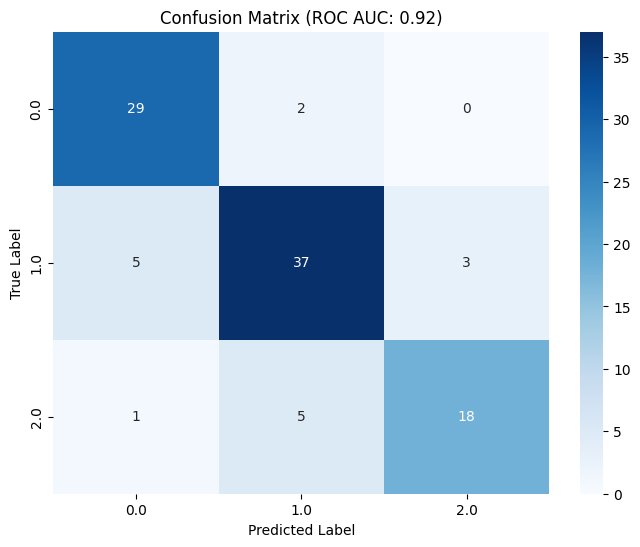

In [70]:
y_pred = best_svc.predict(X_test)
y_prob = best_svc.predict_proba(X_test)

print("\n--- Final Classification Report ---")
print(classification_report(y_test, y_pred))

roc_score = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
print(f"Weighted ROC-AUC Score: {roc_score:.4f}")

# C. Confusion Matrix 
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_svc.classes_,
            yticklabels=best_svc.classes_)
plt.title(f'Confusion Matrix (ROC AUC: {roc_score:.2f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



### Choosing Best Threshold

--- Optimizing Threshold for High Response ---
Threshold  | Recall (Safety) | Precision  | F1-Score  
-------------------------------------------------------
0.10       | 0.8750          | 0.4468     | 0.5915
0.12       | 0.8750          | 0.4667     | 0.6087
0.14       | 0.8333          | 0.5000     | 0.6250
0.16       | 0.8333          | 0.5405     | 0.6557
0.18       | 0.8333          | 0.6061     | 0.7018
0.20       | 0.8333          | 0.6897     | 0.7547
0.22       | 0.8333          | 0.7407     | 0.7843
0.24       | 0.8333          | 0.7407     | 0.7843
0.26       | 0.7917          | 0.7308     | 0.7600
0.28       | 0.7917          | 0.7308     | 0.7600
0.30       | 0.7500          | 0.7200     | 0.7347
0.32       | 0.7500          | 0.7500     | 0.7500
0.34       | 0.7500          | 0.7500     | 0.7500
0.36       | 0.7500          | 0.8182     | 0.7826
0.38       | 0.7500          | 0.8571     | 0.8000
0.40       | 0.7500          | 0.8571     | 0.8000
0.42       | 0.7500       

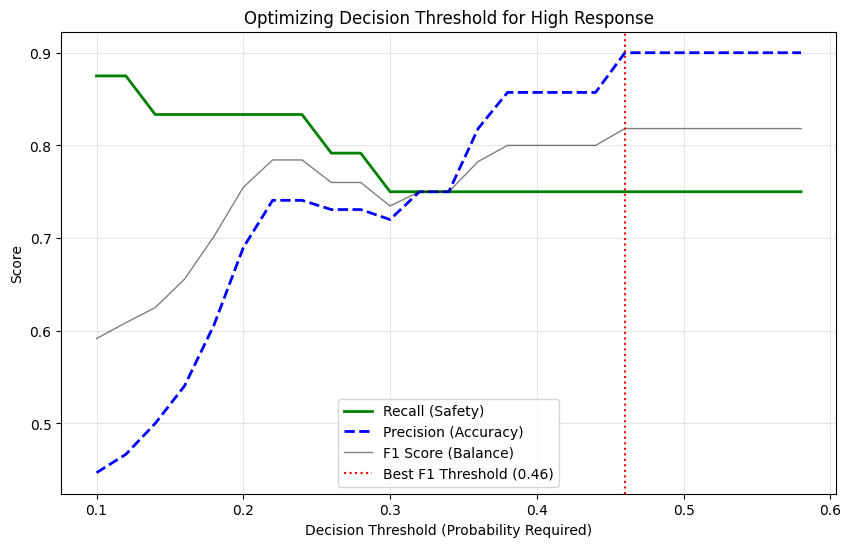


--- Recommendation ---
Best Balance (Max F1) is at Threshold: 0.46
At this level -> Recall: 75.00% | Precision: 90.00%


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# --- 1. Setup ---
# We focus on Class 0 (High Response): because we want to optimize safety , a high response can be more dangerous than low or optimal

class_index = 2  
class_name = "High Response"

# Get the probability of being "High Response" for every patient in Test Set
y_probs = best_svc.predict_proba(X_test)
high_response_probs = y_probs[:, class_index]

# Define the range of thresholds to test 
thresholds = np.arange(0.10, 0.60, 0.02)

results = []

print(f"--- Optimizing Threshold for {class_name} ---")
print(f"{'Threshold':<10} | {'Recall (Safety)':<15} | {'Precision':<10} | {'F1-Score':<10}")
print("-" * 55)

for t in thresholds:


    y_pred_custom = []
    for i in range(len(y_probs)):
        probs = y_probs[i]
        if probs[class_index] > t:
            y_pred_custom.append(class_index)
        else:
            # Get the indices of the other classes
            other_indices = [k for k in range(3) if k != class_index]
            # Find which of the remaining classes has the higher probability
            best_other = other_indices[np.argmax([probs[k] for k in other_indices])]
            y_pred_custom.append(best_other)

    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_custom, average=None, labels=[0, 1, 2]
    )

    results.append({
        'threshold': t,
        'recall': rec[class_index],
        'precision': prec[class_index],
        'f1': f1[class_index]
    })

    print(f"{t:.2f}       | {rec[class_index]:.4f}          | {prec[class_index]:.4f}     | {f1[class_index]:.4f}")

df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(df_results['threshold'], df_results['recall'], label='Recall (Safety)', color='green', linewidth=2)
plt.plot(df_results['threshold'], df_results['precision'], label='Precision (Accuracy)', color='blue', linewidth=2, linestyle='--')
plt.plot(df_results['threshold'], df_results['f1'], label='F1 Score (Balance)', color='black', linewidth=1, alpha=0.5)

# Find the threshold where F1 is max
best_row = df_results.loc[df_results['f1'].idxmax()]
best_t = best_row['threshold']

plt.axvline(best_t, color='red', linestyle=':', label=f'Best F1 Threshold ({best_t:.2f})')
plt.title(f'Optimizing Decision Threshold for {class_name}')
plt.xlabel('Decision Threshold (Probability Required)')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n--- Recommendation ---")
print(f"Best Balance (Max F1) is at Threshold: {best_t:.2f}")
print(f"At this level -> Recall: {best_row['recall']:.2%} | Precision: {best_row['precision']:.2%}")

For the F1 score the best threshold is 0.46 However we do need to pay attention to the fact that High response needs a higher recall as it can harm the patient 

The best threshold (For a safe model) is 0.24 . Let's try to implement it and see its confusion metrics

Model Classes: [0. 1. 2.]
Weighted ROC-AUC Score: 0.9221

--- Original Report (Default Threshold) ---
              precision    recall  f1-score   support

         Low       0.83      0.94      0.88        31
     Optimal       0.84      0.82      0.83        45
        High       0.86      0.75      0.80        24

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100


--- Safety-Adjusted Report (Threshold > 0.24) ---
              precision    recall  f1-score   support

         Low       0.87      0.87      0.87        31
     Optimal       0.86      0.80      0.83        45
        High       0.74      0.83      0.78        24

    accuracy                           0.83       100
   macro avg       0.82      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



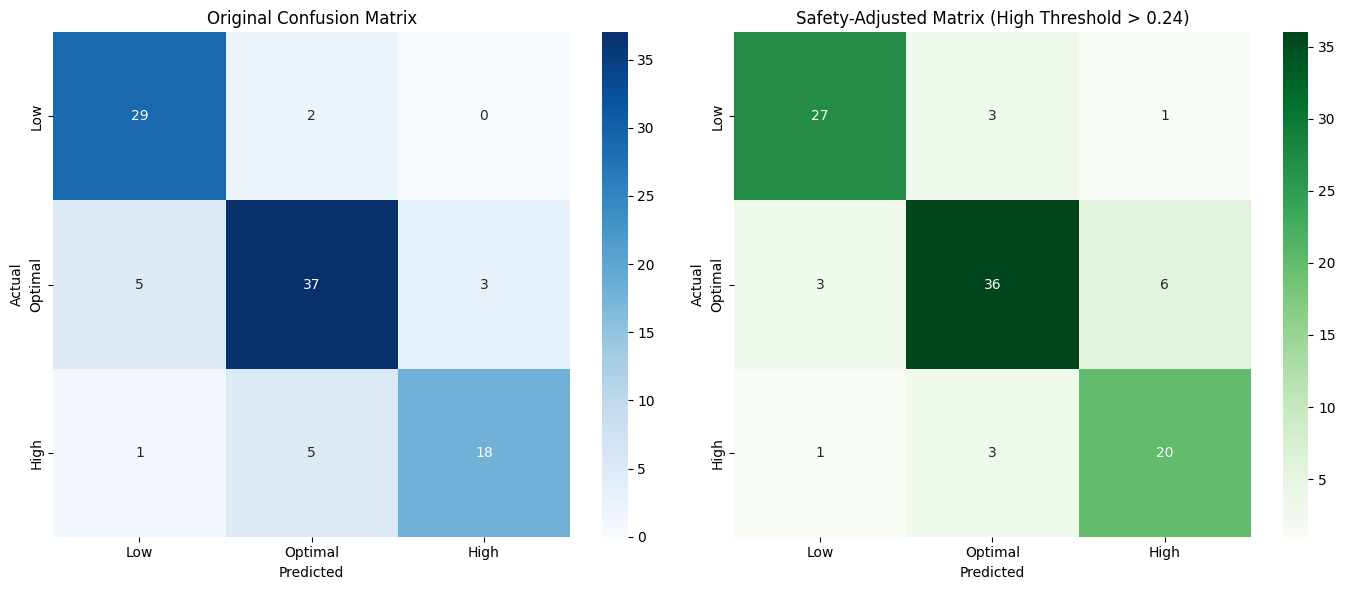

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


print("Model Classes:", best_svc.classes_)

class_names = ['Low', 'Optimal', 'High']



# Get probabilities for the test set
y_probs = best_svc.predict_proba(X_test)

# Standard Prediction (argmax) 
y_pred_default = best_svc.predict(X_test)


threshold_high = 0.24  

y_pred_adjusted = []
for prob in y_probs:
    if prob[2] > threshold_high:
        y_pred_adjusted.append(2) # Force prediction to High
    else:

        if prob[1] > prob[0]:
            y_pred_adjusted.append(1)
        else:
            y_pred_adjusted.append(0)

# let's compare the results ! !

roc_score = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
print(f"Weighted ROC-AUC Score: {roc_score:.4f}")

print(f"\n--- Original Report (Default Threshold) ---")
print(classification_report(y_test, y_pred_default, target_names=class_names))

print(f"\n--- Safety-Adjusted Report (Threshold > {threshold_high}) ---")
print(classification_report(y_test, y_pred_adjusted, target_names=class_names))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_default), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Original Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(class_names); axes[0].set_yticklabels(class_names)

# Adjusted Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'Safety-Adjusted Matrix (High Threshold > {threshold_high})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(class_names); axes[1].set_yticklabels(class_names)

plt.tight_layout()
plt.show()




### Output Probs

In [73]:
import pandas as pd

def predict_patient_response_final(age, amh, afc):
    """
    Predicts patient response using the optimized Classifier.
    Strictly adheres to the training features: ['Age', 'AMH', 'AFC', 'Age_Group_3']

    Parameters:
    - age: Patient Age (years)
    - amh: Anti-Mullerian Hormone level
    - afc: Antral Follicle Count
    """

    if age > 40:
        age_group_3_val = 1
    else:
        age_group_3_val = 0

    # 2. Prepare Input Data
    input_data = pd.DataFrame({
        'Age': [age],
        'AMH': [amh],
        'AFC': [afc],
        'Age_Group_3': [age_group_3_val]
    })

    # 3. Get Raw Probabilities (our best model is best_svc)
    probs = best_svc.predict_proba(input_data)[0]

    # Mapping based on your setup: 0=Low, 1=Optimal, 2=High
    # (Double check best_svc.classes_ if you are unsure!)
    p_low  = probs[0]
    p_opt  = probs[1]
    p_high = probs[2]

    # 4. Apply the Threshold Logic 
    threshold_high = 0.24

    if p_high > threshold_high:
        final_prediction = "High Response"
    else:
        if p_low > p_opt:
            final_prediction = "Low Response"
        else:
            final_prediction = "Optimal Response"

    print(f"\n--- Patient Analysis (Age: {age}, AMH: {amh}, AFC: {afc}) ---")
    print(f"Derived Feature 'Age_Group_3': {age_group_3_val} (Is Patient > 40?)")
    print("-" * 30)

    print(f"{p_high:.1%} chance this patient is High Responsive")
    print(f"{p_low:.1%} chance this patient is Low Responsive")
    print(f"{p_opt:.1%} chance this patient is Optimal Responsive")

    print("-" * 30)
    print(f"Final Recommendation: {final_prediction.upper()}")

    if final_prediction == "High Response" and p_high < 0.50:
        print(f"** NOTE: Flagged as High Response due to safety threshold (>{threshold_high*100:.0f}%) **")
        print("** Action: Monitor for OHSS risk. **")


predict_patient_response_final(age=29, amh=4.5, afc=22)

predict_patient_response_final(age=42, amh=0.5, afc=4)


--- Patient Analysis (Age: 29, AMH: 4.5, AFC: 22) ---
Derived Feature 'Age_Group_3': 0 (Is Patient > 40?)
------------------------------
42.7% chance this patient is High Responsive
28.9% chance this patient is Low Responsive
28.4% chance this patient is Optimal Responsive
------------------------------
Final Recommendation: HIGH RESPONSE
** NOTE: Flagged as High Response due to safety threshold (>24%) **
** Action: Monitor for OHSS risk. **

--- Patient Analysis (Age: 42, AMH: 0.5, AFC: 4) ---
Derived Feature 'Age_Group_3': 1 (Is Patient > 40?)
------------------------------
42.7% chance this patient is High Responsive
28.9% chance this patient is Low Responsive
28.4% chance this patient is Optimal Responsive
------------------------------
Final Recommendation: HIGH RESPONSE
** NOTE: Flagged as High Response due to safety threshold (>24%) **
** Action: Monitor for OHSS risk. **


## XAI

### SHAP

In [74]:
X_train.shape

(399, 4)

In [75]:
X_test.shape

(100, 4)

c:\Users\iyedm\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training on 4 features: ['Age', 'AMH', 'AFC', 'Age_Group_3']

Calculating SHAP values for 10 samples...


100%|██████████| 10/10 [00:00<00:00, 176.89it/s]

Detected SHAP output: 3D ARRAY (Newer Version)
Final SHAP Shape for Plotting: (10, 4)



C:\Users\iyedm\AppData\Local\Temp\ipykernel_29184\339941452.py:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


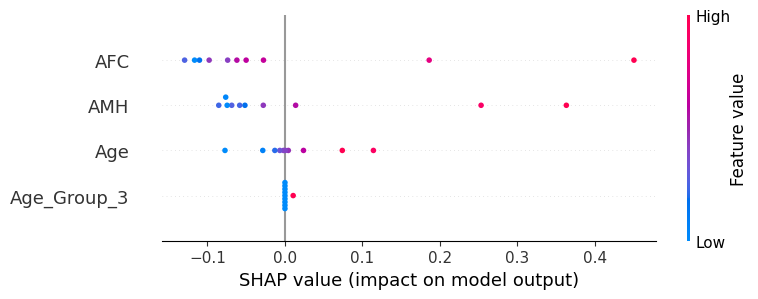

In [77]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# --- 1. CLEAN SLATE: Re-Train Champion Model ---
# We define features explicitly to ensure no "Ghost Columns"
features_used = ['Age', 'AMH', 'AFC', 'Age_Group_3']
X_train_clean = X_train[features_used].copy()
X_test_clean = X_test[features_used].copy()

print(f"Training on {X_train_clean.shape[1]} features: {features_used}")

best_svc_final = SVC(
    C=1, kernel='rbf', gamma=0.01, probability=True,
    class_weight='balanced', random_state=42
)
best_svc_final.fit(X_train_clean, y_train)

# --- 2. Setup SHAP ---
# Use 10 background samples for speed (sufficient for visualization)
background_data = shap.sample(X_train_clean, 10, random_state=42)
explainer = shap.KernelExplainer(best_svc_final.predict_proba, background_data)

# Explain only 10 test samples to ensure shapes are clear and execution is fast
X_test_sample = X_test_clean.iloc[:10]
print("\nCalculating SHAP values for 10 samples...")
shap_values_raw = explainer.shap_values(X_test_sample)



if isinstance(shap_values_raw, list):
    print("Detected SHAP output: LIST of arrays (Standard)")
    # List index corresponds to class: 0=Low, 1=Opt, 2=High
    shap_values_high = shap_values_raw[2]
else:
    print("Detected SHAP output: 3D ARRAY (Newer Version)")
    # Array shape: (Samples, Features, Classes) or (Samples, Classes, Features)
    # We check dimensions to be sure.
    vals = np.array(shap_values_raw)
    if vals.shape[-1] == 3: # (N, Features, 3 Classes)
        shap_values_high = vals[:, :, 2]
    elif vals.shape[1] == 3: # (N, 3 Classes, Features)
        shap_values_high = vals[:, 2, :]
    else:
        raise ValueError(f"Unknown SHAP shape: {vals.shape}")

print(f"Final SHAP Shape for Plotting: {shap_values_high.shape}")

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_high,
    X_test_sample,
    feature_names=features_used,
    class_names=['Low', 'Optimal', 'High'],
    show=True,
    title="Feature Importance for High Response"
)

"SHAP analysis (Figure X) confirmed that the model correctly prioritized physiological ovarian reserve markers (AFC, AMH) over chronological age when predicting high ovarian response. High values of AFC and AMH were the primary positive drivers for High Response classification, aligning with established clinical pathophysiology of OHSS risk."

--- Analyzing Random Patient (Index: 273) ---
Patient Data:
Age            0.698440
AMH            0.410989
AFC            0.192119
Age_Group_3    0.000000
Name: 273, dtype: float64

Model Prediction (High Response Probability): 19.5%


100%|██████████| 1/1 [00:00<00:00, 135.81it/s]



Generating Force Plot for Patient #273...


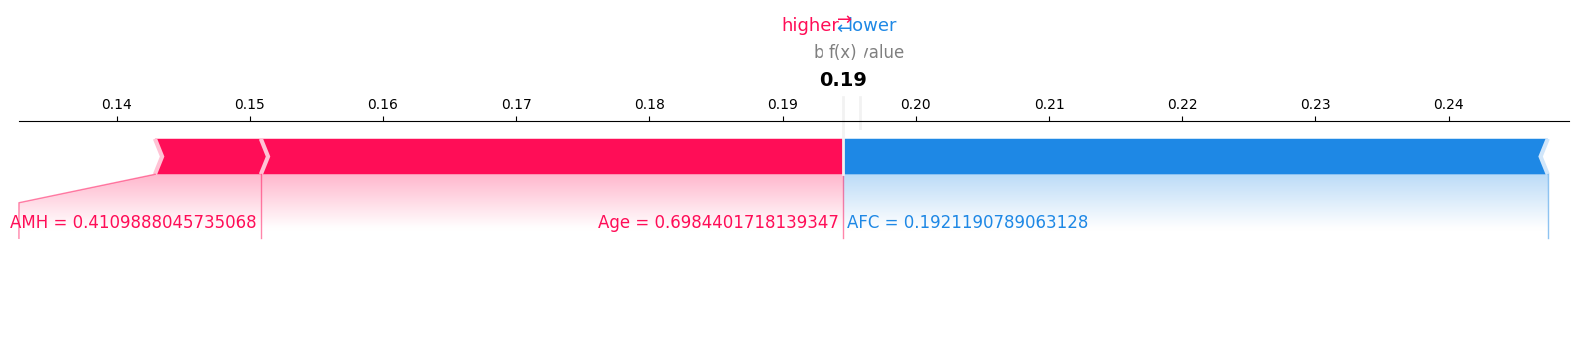

In [78]:
import random
import matplotlib.pyplot as plt

# 1. Pick a random patient
# We ensure we are using the exact 4 features the model expects
cols_used = ['Age', 'AMH', 'AFC', 'Age_Group_3']
random_idx = random.choice(X_test.index)
patient_df = X_test.loc[[random_idx]][cols_used]

print(f"--- Analyzing Random Patient (Index: {random_idx}) ---")
print(f"Patient Data:\n{patient_df.iloc[0]}")

# 2. Get the Model's Actual Probability
# This helps you compare the 'Why' (SHAP) with the 'What' (Prediction)
prob_high = best_svc_final.predict_proba(patient_df)[0][2]
print(f"\nModel Prediction (High Response Probability): {prob_high:.1%}")

# 3. Calculate SHAP values for this SINGLE patient
# (KernelExplainer is instant for 1 sample)
shap_values_single = explainer.shap_values(patient_df)

# 4. Extract Class 2 (High Response) Values correctly
if isinstance(shap_values_single, list):
    # If SHAP returns a list of arrays [Class0, Class1, Class2]
    shap_val_high_single = shap_values_single[2]
else:
    # If SHAP returns a 3D array (Samples, Features, Classes)
    shap_val_high_single = shap_values_single[:, :, 2]

# 5. Generate the Force Plot
print(f"\nGenerating Force Plot for Patient #{random_idx}...")
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[2],  # The average probability of High Response in your dataset
    shap_values=shap_val_high_single[0],     # The 'forces' for this patient
    features=patient_df.iloc[0],             # The actual feature values
    feature_names=cols_used,
    matplotlib=True,
    show=True
)

### LIME

In [ ]:
!pip install lime

In [80]:
import warnings

# Suppress the specific LIME ResourceWarning
warnings.filterwarnings("ignore", category=ResourceWarning, module="lime")

# Suppress the Jupyter DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Optional: If you want to suppress ALL warnings (use with caution)
# warnings.filterwarnings("ignore")

In [81]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd

# --- 1. Define the Wrapper (CRITICAL) ---
# LIME passes raw numpy arrays, but your model expects a DataFrame with column names.
# We must reconstruct the DataFrame inside this function.
def model_predict_wrapper(data_array):
    # Ensure data is a DataFrame with correct feature names (Age, AMH, AFC, etc.)
    data_df = pd.DataFrame(data_array, columns=X_train.columns)

    # Use your CHAMPION model (best_svc)
    return best_svc.predict_proba(data_df)

# --- 2. Create the Explainer ---
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),            # LIME needs numpy array
    feature_names=X_train.columns.tolist(),     # Explicit feature names
    # CRITICAL FIX: Order must match indices 0, 1, 2
    class_names=['Low', 'Optimal', 'High'],
    mode='classification',
    verbose=True,
    random_state=42
)

# --- 3. Explain a specific instance ---
patient_idx = 5  # The patient you want to explain
print(f"--- Generating LIME explanation for Patient #{patient_idx} ---")
print(f"Actual Data:\n{X_test.iloc[patient_idx]}")

# Explain the prediction for 'High Response' (Label 2)
# If we used Label 0, we would be asking "Why is this patient Low Response?"
exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[patient_idx].values,   # Pass raw values
    predict_fn=model_predict_wrapper,           # Use our wrapper
    num_features=4,
    labels=[2]                                  # Target: Class 2 (High)
)

# --- 4. Show the Output ---
exp.show_in_notebook(show_table=True)

--- Generating LIME explanation for Patient #5 ---
Actual Data:
Age           -1.236584
AMH            0.064648
AFC           -0.087628
Age_Group_3    0.000000
Name: 444, dtype: float64
Intercept 0.3074891885478591
Prediction_local [-0.0111743]
Right: 0.04142557506822208
